1 Prepração do notebook
2 Obtenção dos dados, tratamento e geração de Data Frames

* Dados sobre Covid
    * Obtenção de dados do COVID19 e geração do Data Frame df_covid19_br
    * Geração do df_covid19_br_para_shapefile com tratamento dos dados
    * Geração do Geo Data Frames gdf_covid19_br, com os casos para o Brasil, e gdf_covid19_pr, com os casos do Paraná
* Obtenção dos Demais dados
* nível de hierarquia urbana
* população
* mobilidade pendular
* níveis de exportação
* pib percapita
* número de pessoas com renda elevada (a definir o critério)
* tentar identificar uma forma de criar uma base que se atualize dinamicamente e identifique avizinhamento de municípios 0 e 1 

3 Análise Exploratória Correlações

* Gerar painel de estatística descritiva

* Gerar gráficos de distribuição
* Fazer matriz de correlações

4 Modelização

# Obtenção, tratamento e Análise Exploratória dos dados sobre COVID-19 no Brasil

## Preparação do Notebook

* Importação das principais bibliotecas
* Configuração das operações por default (estilos e tamanhos de gráficos)
* Referenciamento das subpastas do projeto

In [1]:
# importação de bibliotecas básicas

import pandas as pd # Biblioteca para operação avançada com dados tabulares de diversos tipos
import numpy as np # Biblioteca para operação com vetores de auto desempenho e um tipo por vez
from matplotlib import use as mpl_use # Função Matplotlib que estabelece backend e precisa ser chamda antes do plt
mpl_use('nbagg') # uso do backend "nbagg" para os gráficos terem paineis interativos
import matplotlib.pyplot as plt # Biblioteca para geração de gráficos de menor nível de abstração
import seaborn as sns # Biblioteca baseada em matplotlib para geração de gráficos e estilização, com maior nível de abstração
import geopandas as gpd # Biblioteca de análise geográfica
import descartes # Dependência do Geopandas para poder gerar mapas
import matplotlib 
import os

In [2]:
# configurações das operações por default

# Configuração de DataFrame Pandas para formato numérico com duas casas decimais quando a coluna for float
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Apresentação dos gráficos no interior das células
%matplotlib inline 
plt.style.use('ggplot') # Apresentação dos gráficos

# Códigos abaixo são configurações que deixo por opção, caso se tornem úteis em alguma operação
# Configuração das Células para que apresentam múltiplos resultados em vez de apenas o último 
# InteractiveShell.ast_node_interactivity = "all"
# sns.set() # Configuração de Gráficos para padrão de formatação básica da biblioteca Seaborn

In [3]:
# referenciamento das subpastas

diretorio_economia = os.path.join(os.getcwd(),'base_de_dados','economia')
diretorio_casos = os.path.join(os.getcwd(),'base_de_dados','boletins_de_casos')
diretorio_hierarquia_urbana = os.path.join(os.getcwd(),'base_de_dados','hierarquia_urbana')
diretorio_infra_atendimento = os.path.join(os.getcwd(),'base_de_dados','infraestrutura_atendimento')
diretorio_populacao = os.path.join(os.getcwd(),'base_de_dados','populacao')
diretorio_transporte_rodoviario = os.path.join(os.getcwd(),'base_de_dados','transporte_rodoviario')
diretorio_turismo = os.path.join(os.getcwd(),'base_de_dados','turismo')
diretorio_estrutura_territorial = os.path.join(os.getcwd(),'base_de_dados','estrutura_territorial')


## Importação e Tratamento Preliminar dos Dados

* Verificação da Estrutura dos dados
* Observação da pertinência dos tipos
* Identificação e tratamento dos dados nulos
* Codificação de variáveis categóricas
* Separação dos batches
    * Estratificado
    * Não Estratificado
* Criar versão com regularização de escala

São criados três DataFrames

* Dados de Notificações nos municípios brasileiros
    * df_covid_19_br - dados de notificações nos municípios brasileiros
    * df_casos_sem_referencia_municipal
    * df_covid_19_br_to_shape - dados de notificações readequados para importação em ambiente de Sistemas de Informações Geográficas 
    * df_data_primeiro_caso - dados dos da data do primeiro caso

### Dados de notificações nos municípios brasileiros
* Abaixo se encontra uma função colect_cases, que obtem os dados sobre COVID-19 compilados dos boletins e disponível em "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv"
    * Os dados são salvos em Pandas Data Frame
    * Os nomes das colunas são corrigidos
    * As duplicidades são eliminadas, pela retirada de várias linhas com totais

Observações: É conveniente que, no futuro, a função tenha um tratamento para que as datas não estejam em formato texto

In [4]:
def colect_cases(output=None, output_format='csv', correct_columns=True, correct_rows=True):
    # Retrieves the notified cases in Brazilian boletins found in
    # https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv
    # correct_columns -> whether or not to rearrange the columns and rename them
    # Correct_rows -> whether or not to remove the total cases by date, which would duplicate the values per day
    # name_csv -> string withe name of the csv file to save the content of the Data Frame. If name_csv equals to None, no file is saved

    # loads the CSV data into df_cases
    df_cases = pd.read_csv(
        'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv',
        parse_dates=True,
        infer_datetime_format=True)

    # if correct_columns == True, it rearranges the columns orders and renames them
    if correct_columns == True:
        df_cases = df_cases[['ibgeID', 'city', 'state', 'date', 'newCases', 'totalCases']].rename(
            columns={'ibgeID': 'cod_mun', 'city': 'municipio', 'state': 'estado', 'date': 'data', 'newCases': 'novos_casos', 'totalCases': 'casos_total'})

    # if correct_rows == True, it removes the rows that show the total cases by date, which would duplicate the values per day
    if correct_rows == True:
        filter_cases_total = df_cases.loc[df_cases.estado == 'TOTAL']
        df_cases.drop(filter_cases_total.index, axis=0, inplace=True)

    # removes the state name in the municipality column
    df_cases.municipio = df_cases.municipio.apply(
        lambda a_corrigir: a_corrigir.split('/')[0])

    # if name_csv contains the name of a csv file, a file will be created in the current directory
    # or in the specified directory
    if output != None:
        if output_format == 'csv':
            df_cases.to_csv(output, encoding='utf-16')
        if output_format == 'excel':
            df_cases.to_excel(output, encoding='utf-16')

    return df_cases

Importação, observação e tratamento preliminar dos dados

* Criação do Data Frame df_covid_19_br
* observação preliminar dos dados
* identificação de sua estrutura de linhas e colunas

**Data Frame df_covid_19_br**

In [5]:
df_covid_19_br = colect_cases()
df_covid_19_br

,cod_mun,municipio,estado,data,novos_casos,casos_total
0,3550308,São Paulo,SP,2020-02-25,1,1
2,3550308,São Paulo,SP,2020-02-26,0,1
4,3550308,São Paulo,SP,2020-02-27,0,1
6,3550308,São Paulo,SP,2020-02-28,1,2
8,3550308,São Paulo,SP,2020-02-29,0,2
...,...,...,...,...,...,...
12303,5108402,Várzea Grande,MT,2020-04-12,0,6
12304,5200258,Águas Lindas de Goiás,GO,2020-04-12,0,2
12305,4200606,Águas Mornas,SC,2020-04-12,0,1
12306,3500501,Águas de Lindóia,SP,2020-04-12,0,1


**Informações da estrutura do Data Frame df_covid_19_br**<br>
O Data Frame df_covid_19_br conta com {{len(df_covid_19_br.index)}} linhas e {{len(df_covid_19_br.columns)}} colunas.
A estrutura do df_covid_19_br não é adequada para importação em formato shapefile, necessário para geração de cartogramas 

In [6]:
df_covid_19_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12261 entries, 0 to 12307
Data columns (total 6 columns):
cod_mun        12261 non-null int64
municipio      12261 non-null object
estado         12261 non-null object
data           12261 non-null object
novos_casos    12261 non-null int64
casos_total    12261 non-null int64
dtypes: int64(3), object(3)
memory usage: 670.5+ KB


**verificação de dados faltantes**

O heatmap abaixo e a série de dados adiante mostram que não existe célula em branco no Data Frame df_covid_19_br

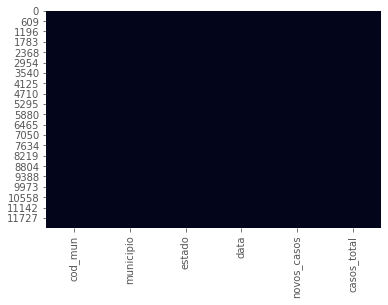

In [7]:
#gráfico heatmap para identificação do padrão de distribuição dos valores nulos no Data Frame
sns.heatmap(df_covid_19_br.isnull(), cbar=False); 

In [8]:
df_covid_19_br.isnull().sum()

cod_mun        0
municipio      0
estado         0
data           0
novos_casos    0
casos_total    0
dtype: int64

**Dados sem associação com municípios**<br>
Algumas linhas contam o número de casos, mas sem associar a seus municípios, colocando-os como Fora do Estado, Estrangeiro e No-INFO

In [9]:
filter_len_cod_mun = df_covid_19_br.cod_mun.astype('str').str.len() == 2
filter_last_date = df_covid_19_br.data == df_covid_19_br.data.max()

df_casos_sem_referencia_municipal = df_covid_19_br[filter_len_cod_mun]

df_casos_sem_referencia_municipal.head()

,cod_mun,municipio,estado,data,novos_casos,casos_total
23,32,INDEFINIDA,ES,2020-03-06,1,1
24,35,INDEFINIDA,SP,2020-03-06,4,4
31,32,INDEFINIDA,ES,2020-03-07,0,1
40,32,INDEFINIDA,ES,2020-03-08,0,1
50,32,INDEFINIDA,ES,2020-03-09,0,1


In [10]:
df_casos_sem_referencia_municipal.municipio.value_counts(),

(INDEFINIDA    347
 Name: municipio, dtype: int64,)

In [11]:
df_casos_sem_referencia_municipal[['municipio','casos_total']].groupby(by='municipio', axis=0).sum()

,casos_total
municipio,
INDEFINIDA,5581


**data frame dos primeiros casos**

In [12]:
#geração do Data Frame com a data do primeiro caso por municípios

dic_data_inicial = {}
cod_municipios = df_covid_19_br[~filter_len_cod_mun].cod_mun.unique()
for codigo in cod_municipios:
    data_inicial = df_covid_19_br[df_covid_19_br.cod_mun == codigo]['data'].min()
    dic_data_inicial[codigo] = data_inicial

df_data_primeiro_caso = pd.DataFrame(data=dic_data_inicial.values(), index=dic_data_inicial.keys(), columns = ['data_primeiro_caso'])

df_data_primeiro_caso

,data_primeiro_caso
3550308,2020-02-25
3300407,2020-03-05
2910800,2020-03-06
3304557,2020-03-06
5300108,2020-03-07
...,...
3124302,2020-04-12
3140308,2020-04-12
3145208,2020-04-12
3149903,2020-04-12


**Geração do Shapefile com os dados de CoronaVirus**

In [13]:
def preparing_shape_data(df):
    
    
    # retira os casos do estado que não estão associados a municipios
    filter_len_cod_mun = df.cod_mun.astype('str').str.len() == 2 #filtro de cod_mun de apenas dois caracteres
    df = df[~filter_len_cod_mun] # Retira do Data Frame df as linhas em que cod_mun tem apenas dois caracteres 
    
    # pivoteia o df, com cod_mun na linha, datas nas colunas e casos totais como valores
    df = df[['cod_mun',
              'data',
              'casos_total']].pivot_table(index='cod_mun', columns='data', values='casos_total')
    
    # corrige o nome das colunas
    list_new_column_names = []
    for old_name in df.columns:
        new_name = 'dia' + old_name.split('-')[2]+ old_name.split('-')[1]
        list_new_column_names.append(new_name)
    df.columns = list_new_column_names
    
    
    
    #list_new_column_names = []
    #for old_column_name in df.columns:
    #    new_name = 'dia' + old_column_name.split('-')[1] + old_column_name.split('-')[0]
    #    list_new_column_names.append(new_name)
    #df.columns = list_new_column_names
    
    # insere 0 nos casos em que o valores são nulos
    df.fillna(0, inplace=True)
    
    # transforma os dados em integers
    
    df = df.astype('int32')
    
    
    return df

In [14]:
# Gera o Data Frame com os dados de COVID no formato adequado para importação em Geo Data Frame
df_covid_19_br_to_shape = preparing_shape_data(df_covid_19_br)

In [15]:
# visualização do Data Frame com os dados para importação em Geo Data Frame
df_covid_19_br_to_shape

,dia2502,dia2602,dia2702,dia2802,dia2902,dia0103,dia0203,dia0303,dia0403,dia0503,...,dia0304,dia0404,dia0504,dia0604,dia0704,dia0804,dia0904,dia1004,dia1104,dia1204
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2
1100114,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1100122,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1100155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
1100205,0,0,0,0,0,0,0,0,0,0,...,8,9,10,14,19,21,23,23,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220603,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
5221403,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2,2,2,3,3
5221858,0,0,0,0,0,0,0,0,0,0,...,5,5,5,6,6,6,6,6,6,6


In [16]:
# Cria o Geo Data Frame com base na shapefile de todos os municipios do Brasil
gdf_municipios_br = gpd.read_file('BRMUE250GC_SIR.shp', encoding='utf-8')
gdf_municipios_br

,NM_MUNICIP,CD_GEOCMU,geometry
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755..."
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034..."
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2..."
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2..."
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731..."
...,...,...,...
5567,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3..."
5568,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9..."
5569,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7..."
5570,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9..."


In [17]:
# Verifica a estrutura do Geo Data Frame
gdf_municipios_br.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
NM_MUNICIP    5572 non-null object
CD_GEOCMU     5572 non-null object
geometry      5572 non-null geometry
dtypes: geometry(1), object(2)
memory usage: 130.7+ KB


In [18]:
# Renomeia as colunas do Geo Data Frame
gdf_municipios_br.columns = ['municipio', 'cod_mun', 'geometry']

In [19]:
# Altera o tipo da coluna cod_mun no Geo Data Frame para integer
gdf_municipios_br.cod_mun  = pd.to_numeric(gdf_municipios_br.cod_mun, downcast='integer')

In [20]:
# Expande o Data Frame df_covid_19_br_to_shape para que tenha os mesmos indexes encontrados no Geo Data Frame

df_covid_19_br_to_shape = df_covid_19_br_to_shape.reindex(gdf_municipios_br.cod_mun.values)

In [21]:
# Faz a junção entre Geo Data Frame e o Data Frame 

gdf_municipios_br = gdf_municipios_br.merge(df_covid_19_br_to_shape, on='cod_mun')

In [22]:
gdf_municipios_br.iloc[:, 3:] = gdf_municipios_br.iloc[:, 3:].fillna(0)

In [23]:
gdf_municipios_br.nlargest(n=10, columns='dia3003')

,municipio,cod_mun,geometry,dia2502,dia2602,dia2702,dia2802,dia2902,dia0103,dia0203,...,dia0304,dia0404,dia0504,dia0604,dia0704,dia0804,dia0904,dia1004,dia1104,dia1204
2537,SÃO PAULO,3550308,"POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...",1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,3202.0,3496.0,3612.0,3754.0,4258.0,4947.0,5477.0,5982.0,6131.0,6131.0
1067,RIO DE JANEIRO,3304557,"MULTIPOLYGON (((-43.70288 -22.98523, -43.70286...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,867.0,982.0,1068.0,1110.0,1251.0,1449.0,1633.0,1808.0,1905.0,1905.0
440,FORTALEZA,2304400,"POLYGON ((-38.56771 -3.84953, -38.57672 -3.845...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,600.0,681.0,869.0,929.0,1053.0,1238.0,1283.0,1366.0,1457.0,1457.0
2557,BRASÍLIA,5300108,"POLYGON ((-47.81455 -16.04995, -47.81478 -16.0...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,419.0,456.0,468.0,485.0,503.0,509.0,527.0,556.0,592.0,614.0
3566,BELO HORIZONTE,3106200,"POLYGON ((-43.92060 -19.80202, -43.92021 -19.8...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,225.0,237.0,262.0,264.0,275.0,299.0,310.0,330.0,338.0,355.0
1072,PORTO ALEGRE,4314902,"MULTIPOLYGON (((-51.28678 -30.12193, -51.28710...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,233.0,241.0,254.0,253.0,272.0,279.0,303.0,303.0,311.0,311.0
2346,MANAUS,1302603,"POLYGON ((-59.92021 -2.61052, -59.91470 -2.616...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,232.0,283.0,379.0,473.0,560.0,712.0,800.0,863.0,932.0,932.0
3087,SALVADOR,2927408,"POLYGON ((-38.39181 -12.84328, -38.39180 -12.8...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,183.0,215.0,244.0,263.0,269.0,292.0,314.0,343.0,355.0,355.0
4876,CURITIBA,4106902,"POLYGON ((-49.24591 -25.34942, -49.24536 -25.3...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,114.0,153.0,172.0,175.0,194.0,205.0,237.0,251.0,279.0,279.0
1713,RECIFE,2611606,"POLYGON ((-34.91029 -7.95375, -34.91285 -7.969...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,92.0,119.0,139.0,146.0,221.0,254.0,340.0,413.0,486.0,486.0


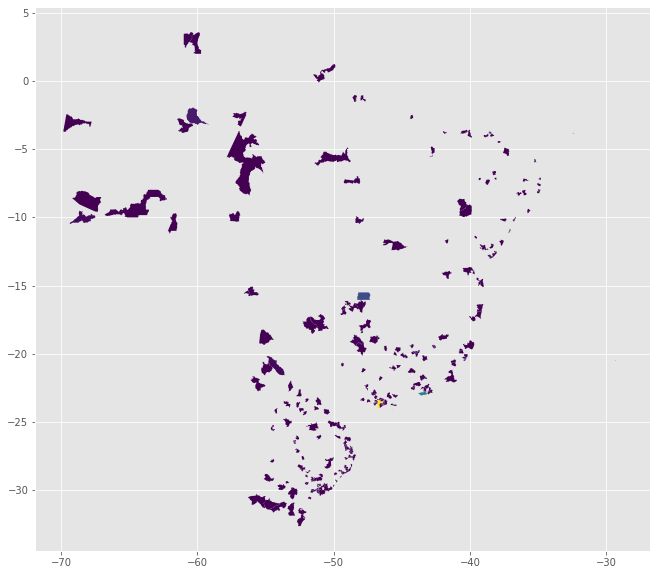

In [24]:
gdf_municipios_br[gdf_municipios_br['dia2703'] != 0].plot(column='dia2703', figsize=(15, 10))

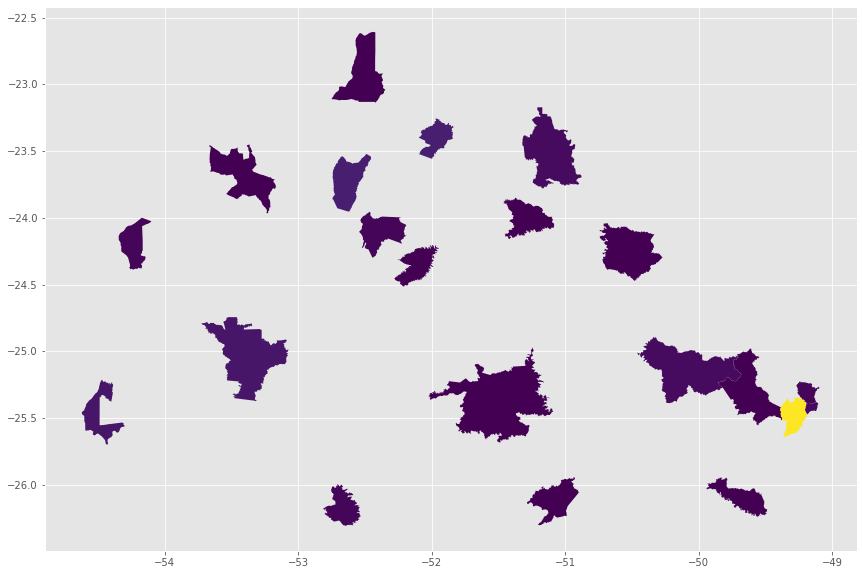

In [25]:
filtro_parana = (gdf_municipios_br.cod_mun.astype('str').str[0:2] == '41') & (gdf_municipios_br['dia2703'] != 0)
gdf_municipios_br[filtro_parana].plot(column='dia2703', figsize=(15, 10))

### Dados de Fatores Geográficos

In [26]:
df_fatores_geograficos = pd.read_csv('base_compilada_de_fatores_geograficos.csv', delimiter=';', encoding='utf-8')

In [27]:
df_fatores_geograficos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 15 columns):
cod_mun                 5570 non-null int64
UF                      5570 non-null object
Município               5570 non-null object
pop2019                 5570 non-null int64
pib2017milreais         5570 non-null int64
export_fob_2019         5570 non-null int64
import_fob_2019         5570 non-null int64
pip_per_capita17        5570 non-null int64
hierarquia_urbana07     5570 non-null object
hierarquia              5570 non-null int64
voos_dom                5570 non-null int64
voos_int                5570 non-null int64
indice_proximidade      5570 non-null object
indice_intermediacao    5570 non-null object
turismo                 5570 non-null int64
dtypes: int64(10), object(5)
memory usage: 652.9+ KB


In [28]:
df_fatores_geograficos.describe()

,cod_mun,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia,voos_dom,voos_int,turismo
count,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000
mean,3.253591e+06,3.772839e+04,1.181924e+06,4.040838e+07,3.183982e+07,2199.074686,1.715440,12.081688,1.002693,1.110772
std,9.849103e+05,2.214581e+05,1.162173e+07,3.099210e+08,3.122626e+08,2094.632926,1.921235,254.325169,40.658039,1.308745
min,1.100015e+06,7.810000e+02,1.299300e+04,0.000000e+00,0.000000e+00,329.000000,1.000000,0.000000,0.000000,0.000000
25%,2.512126e+06,5.446500e+03,7.910150e+04,0.000000e+00,0.000000e+00,949.000000,1.000000,0.000000,0.000000,0.000000
50%,3.146280e+06,1.163100e+04,1.766215e+05,0.000000e+00,0.000000e+00,1660.000000,1.000000,0.000000,0.000000,0.000000
75%,4.119190e+06,2.549050e+04,4.702212e+05,1.264064e+06,1.648922e+05,2705.000000,1.000000,0.000000,0.000000,2.000000
max,5.300108e+06,1.225202e+07,6.992884e+08,1.130984e+10,1.012971e+10,34485.000000,11.000000,15172.000000,2791.000000,5.000000


In [29]:
df_fatores_geograficos.set_index('cod_mun', inplace=True)

**arranjos populacionais**

In [30]:
df_arranjos_populacionais = pd.read_csv('arranjo_populacional.csv', sep=';', decimal=',')

In [31]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_interna'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_interna'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum();

C:\Users\Acer A315\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_geral'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_geral'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'pessoas_em_pendularidade_trabalho'].sum() / df_arranjos_populacionais.loc[:,'pessoas_em_pendularidade_trabalho'].sum();

In [33]:
df_fatores_geograficos = df_fatores_geograficos.merge(df_arranjos_populacionais.set_index('cod_mun').loc[:,['peso_integracao_interna', 'peso_integracao_geral']], on='cod_mun', how='left')

In [34]:
df_fatores_geograficos

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,voos_dom,voos_int,indice_proximidade,indice_intermediacao,turismo,peso_integracao_interna,peso_integracao_geral
cod_mun,,,,,,,,,,,,,,,,
1100015,RO,Alta Floresta D'Oeste,22945,498864,198695,13294,1961,Centro Local,1,0,0,"0,30416971",0,2,NaN,NaN
1100023,RO,Ariquemes,107863,2296074,38002769,738809,2139,Centro Subregional B,4,0,0,"0,4171477","0,00720614",3,NaN,NaN
1100031,RO,Cabixi,5312,138894,137660,0,2232,Centro Local,1,0,0,"0,23445949",0,2,NaN,NaN
1100049,RO,Cacoal,85359,2127523,20514957,53854,2404,Centro Subregional B,4,25,0,"0,40565826","0,00138341",4,NaN,NaN
1100056,RO,Cerejeiras,16323,448524,97838806,59259,2501,Centro de Zona B,2,0,0,"0,3062666","0,00073794",2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,GO,Vianópolis,13863,395787,0,0,2894,Centro Local,1,0,0,"0,33807385","0,00000349",2,NaN,NaN
5222054,GO,Vicentinópolis,8743,350765,6518444,0,4177,Centro Local,1,0,0,"0,33058859","0,00000455",0,NaN,NaN
5222203,GO,Vila Boa,6171,137500,0,0,2399,Centro Local,1,0,0,"0,29688869","0,00000028",0,NaN,NaN


In [35]:
df_fatores_geograficos.iloc[:,-2:] = df_fatores_geograficos.iloc[:,-2:].fillna(0)
df_fatores_geograficos.iloc[:,-2:]

,peso_integracao_interna,peso_integracao_geral
cod_mun,,
1100015,0.000000,0.000000
1100023,0.000000,0.000000
1100031,0.000000,0.000000
1100049,0.000000,0.000000
1100056,0.000000,0.000000
...,...,...
5222005,0.000000,0.000000
5222054,0.000000,0.000000
5222203,0.000000,0.000000


In [36]:
df_fatores_geograficos[['peso_integracao_interna', 'peso_integracao_geral']].max()

peso_integracao_interna    1.000000
peso_integracao_geral      0.236947
dtype: float64

### Integração dos Dados

In [37]:
df_fatores_geograficos = df_fatores_geograficos.join(df_covid_19_br_to_shape)

In [38]:
df_fatores_geograficos.iloc[:, 16:] = df_fatores_geograficos.iloc[:, 16:].fillna(0)

In [39]:
df_fatores_geograficos = df_fatores_geograficos.join(df_data_primeiro_caso)

In [40]:
df_fatores_geograficos.data_primeiro_caso = pd.to_datetime(df_fatores_geograficos.data_primeiro_caso)

In [41]:
df_fatores_geograficos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 1100015 to 5300108
Data columns (total 65 columns):
UF                         5570 non-null object
Município                  5570 non-null object
pop2019                    5570 non-null int64
pib2017milreais            5570 non-null int64
export_fob_2019            5570 non-null int64
import_fob_2019            5570 non-null int64
pip_per_capita17           5570 non-null int64
hierarquia_urbana07        5570 non-null object
hierarquia                 5570 non-null int64
voos_dom                   5570 non-null int64
voos_int                   5570 non-null int64
indice_proximidade         5570 non-null object
indice_intermediacao       5570 non-null object
turismo                    5570 non-null int64
peso_integracao_interna    5570 non-null float64
peso_integracao_geral      5570 non-null float64
dia2502                    5570 non-null float64
dia2602                    5570 non-null float64
dia2702                  

In [42]:
df_fatores_geograficos['data_padrao'] = pd.to_datetime('2020-02-24')

df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['data_primeiro_caso'].sub(df_fatores_geograficos['data_padrao'], axis=0)


df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['dias_contaminação_referencia'] / np.timedelta64(1, 'D')


In [43]:
df_fatores_geograficos.nlargest(n=10, columns='dias_contaminação_referencia')

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,voos_dom,...,dia0604,dia0704,dia0804,dia0904,dia1004,dia1104,dia1204,data_primeiro_caso,data_padrao,dias_contaminação_referencia
cod_mun,,,,,,,,,,,,,,,,,,,,,
3100203,MG,Abaeté,23237,426042,0,0,1804,Centro de Zona B,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3108107,MG,Bonfim,6868,85997,0,0,1225,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3111606,MG,Campos Gerais,28774,477705,195860,0,1644,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3124302,MG,Espinosa,31617,274227,6248,61564,851,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3140308,MG,Marliéria,4039,39015,0,0,945,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3145208,MG,Nova Serrana,102693,2602636,10350163,4482264,2749,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3149903,MG,Perdões,21390,478385,0,0,2231,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3151107,MG,Pirapetinga,10752,588794,4255558,1150989,5414,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
1301100,AM,Careiro,37869,272381,0,0,728,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-04-11,2020-02-24,47.0


In [44]:
df_fatores_geograficos

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,voos_dom,...,dia0604,dia0704,dia0804,dia0904,dia1004,dia1104,dia1204,data_primeiro_caso,data_padrao,dias_contaminação_referencia
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100015,RO,Alta Floresta D'Oeste,22945,498864,198695,13294,1961,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,2020-02-24,NaN
1100023,RO,Ariquemes,107863,2296074,38002769,738809,2139,Centro Subregional B,4,0,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2020-04-10,2020-02-24,46.0
1100031,RO,Cabixi,5312,138894,137660,0,2232,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,2020-02-24,NaN
1100049,RO,Cacoal,85359,2127523,20514957,53854,2404,Centro Subregional B,4,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,2020-02-24,NaN
1100056,RO,Cerejeiras,16323,448524,97838806,59259,2501,Centro de Zona B,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,2020-02-24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,GO,Vianópolis,13863,395787,0,0,2894,Centro Local,1,0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2020-04-07,2020-02-24,43.0
5222054,GO,Vicentinópolis,8743,350765,6518444,0,4177,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,2020-02-24,NaN
5222203,GO,Vila Boa,6171,137500,0,0,2399,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,2020-02-24,NaN


In [45]:
df_fatores_geograficos.to_csv('fatores_para_k_means.csv', sep=';', decimal=',', encoding='utf-16')

In [46]:
df_fatores_geograficos.nlargest(n=10, columns='dias_contaminação_referencia')

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,voos_dom,...,dia0604,dia0704,dia0804,dia0904,dia1004,dia1104,dia1204,data_primeiro_caso,data_padrao,dias_contaminação_referencia
cod_mun,,,,,,,,,,,,,,,,,,,,,
3100203,MG,Abaeté,23237,426042,0,0,1804,Centro de Zona B,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3108107,MG,Bonfim,6868,85997,0,0,1225,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3111606,MG,Campos Gerais,28774,477705,195860,0,1644,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3124302,MG,Espinosa,31617,274227,6248,61564,851,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3140308,MG,Marliéria,4039,39015,0,0,945,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3145208,MG,Nova Serrana,102693,2602636,10350163,4482264,2749,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3149903,MG,Perdões,21390,478385,0,0,2231,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
3151107,MG,Pirapetinga,10752,588794,4255558,1150989,5414,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-04-12,2020-02-24,48.0
1301100,AM,Careiro,37869,272381,0,0,728,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-04-11,2020-02-24,47.0


In [47]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

NameError: name 'corr' is not defined

In [ ]:
df_fatores_geograficos.to_csv('fatores_total.csv', sep=';', decimal=',', encoding='utf-16')

In [ ]:
df_arranjos_populacionais.loc[:,['cod_mun', 'peso_integracao_interna', 'peso_integracao_geral']]

In [ ]:
df_arranjos_populacionais.loc[:,'peso_integracao_geral'].sum()

In [ ]:
next(iter_test)[1].values[0]

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == next(iter_test)[1].values[0]
df_arranjos_populacionais[filtro_arranjo_pop]

In [ ]:
df_arranjos_populacionais['peso'] = 0

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'São José do Rio Preto/SP'
df_arranjos_populacionais.loc[:,'peso'].sum()

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'Antônio Prado/RS'

#df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'peso'] = 

df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum()


#df_arranjos_populacionais[filtro_arranjo_pop]['p'] = df_arranjos_populacionais[filtro_arranjo_pop].pop_2019.sum()

In [ ]:
df_arranjos_populacionais[filtro_arranjo_pop]['peso']

In [ ]:
df_arranjos_populacionais.loc

In [ ]:
df_covid_19_br.to_csv('base_covid_atualizada.csv', decimal=',', sep=';', encoding='utf-16')

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=np.log(df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);
ax[1].set_title('First Plot')
ax[1].set_title('First Plot')

In [ ]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pib2017milreais'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB Municipal em 2017 (R$1.000)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('PIB Municipal em 2017')


ax[1].scatter(y=np.log(df_fatores_geograficos['pib2017milreais'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB Municipal em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pip_per_capita17'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB per capita em 2017(R$)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pip_per_capita17'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB per capita em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['export_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Exportações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('Exportações em 2019 (FOB)')


ax[1].scatter(y=np.log(df_fatores_geograficos['export_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Exportações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['import_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Importações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['import_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Importações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
plt.scatter?

In [ ]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.5,
            cmap=color_map,
            s=300);


teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Data da primeira notificação')
plt.ylabel('População em 2019');

In [ ]:
plt.legend?

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

scatter = plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.9,
            cmap=color_map,
            s= 300);

ax.set_title('Municípios Brasileiros segundo momento do primeiro Caso de COVID-19, população e hierarquia urbana \n')
teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('primeira notificação (dias a partir de 25 de fevereiro de 2020)')
plt.ylabel('População em 2019 (escala logarítmica)');


plt.savefig('covid.png')
#lgnd = plt.legend(handles=handles, loc="lower left", scatterpoints=1)

#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
#lgnd.legendHandles[0]._sizes = [30]
#lgnd.legendHandles[1]._sizes = [30]

Para melhorar o gráfico acima, preciso pegar uns parâmetros nos links abaixo

https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html

https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D

https://matplotlib.org/3.1.0/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

https://stackoverflow.com/questions/11983024/matplotlib-legends-not-working

Minha intenção é colocar uma quarta variável (PIB) nesse mesmo gráfico

https://stackoverflow.com/questions/24706125/setting-a-fixed-size-for-points-in-legend

https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size

In [ ]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax

In [ ]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax[0,0].scatter(x=np.log(df_fatores_geograficos[variavel][df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()], y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

In [ ]:
df_fatores_geograficos.pop2019

In [ ]:
df_fatores_geograficos.dia3103.max()

In [ ]:
df_fatores_geograficos.columns

In [ ]:
list_colunas_selecionadas = list(df_fatores_geograficos.columns[2:10])
list_colunas_selecionadas.append(df_fatores_geograficos.columns[-3])

In [ ]:
list_colunas_selecionadas

In [ ]:
df_fatores_geograficos_correlacao =  df_fatores_geograficos.loc[:, list_colunas_selecionadas]
df_fatores_geograficos_correlacao

In [ ]:
corr = df_fatores_geograficos_correlacao.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [ ]:
df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0]

In [ ]:
corr = df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao)

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0])

In [ ]:
corr

In [ ]:
df_fatores_geograficos['dia3103'].sum()

In [ ]:
df_fatores_geograficos_semzeros = df_fatores_geograficos[df_fatores_geograficos.iloc[:,-1] != 0]

In [ ]:
plt.scatter(df_fatores_geograficos['pop2019'], df_fatores_geograficos['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao_semzeros['pop2019'], df_fatores_geograficos_correlacao_semzeros['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao['pop2019'], df_fatores_geograficos_correlacao['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao['export_fob_2019'], df_fatores_geograficos_correlacao['dia2903'])

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao[['pop2019', 'dia2903']][df_fatores_geograficos_correlacao.iloc[:,-1] != 0], size=5)

In [ ]:
df_arranjos_populacionais